<a href="https://colab.research.google.com/github/mallang327/EEE4178-Hands-On/blob/main/Day5_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab에 구글드라이브 마운트

In [2]:
# 테스트용 zip 파일
!gdown https://drive.google.com/uc?id=1nhCHhPpfQB30rqzN_2LD8thmrLRt15Bt

Downloading...
From: https://drive.google.com/uc?id=1nhCHhPpfQB30rqzN_2LD8thmrLRt15Bt
To: /content/Sample001.zip
100% 3.59M/3.59M [00:00<00:00, 275MB/s]


In [4]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 구글드라이브에 저장된 zip 파일 압축 풀기
!unzip /content/drive/MyDrive/EEE4178_hands_on/Sample001.zip

## Day 5 
### (1) VAE (Variation Auto Encoder) 

1. 모델의 이해

[\[VAE 논문 pdf\] D. P. Kingma and M. Welling, "Auto-encoding variational bayes," arXiv preprint arXiv:1312.6114, 2013.](https://drive.google.com/file/d/12P6iMPrhvbq4fmdn7fTz5onzoX52bCej/view?usp=sharing)

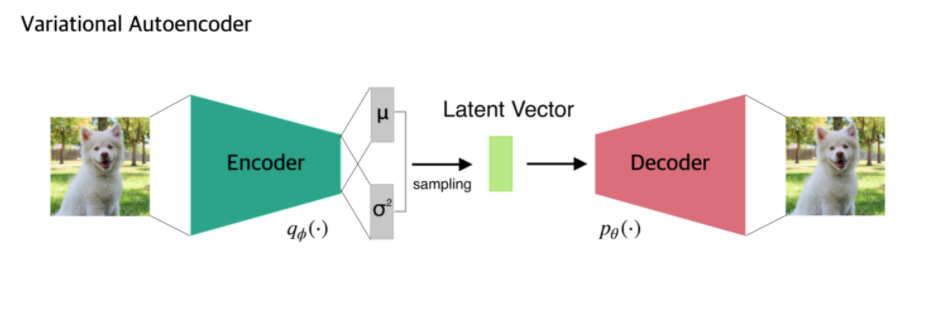

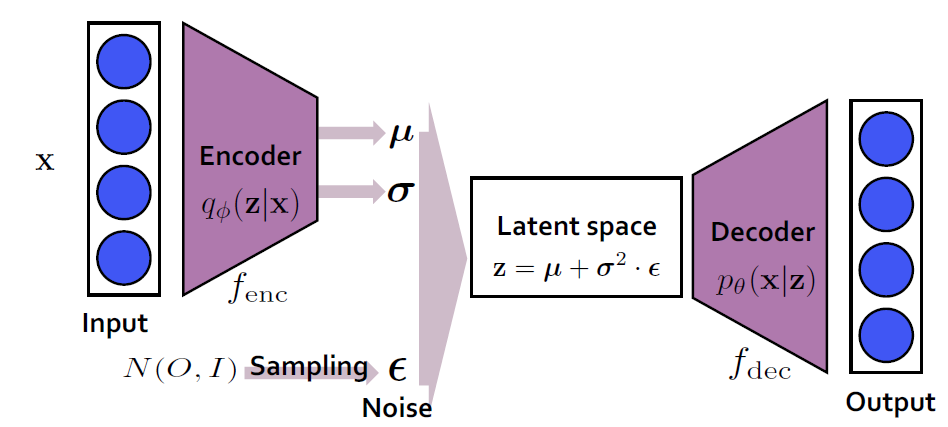

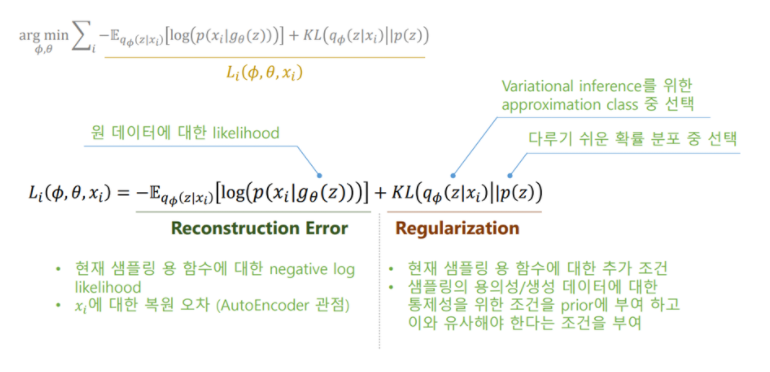

2. Pytorch code with MNIST

 2.1 Define Hyper-parameters / Set configuration

In [ ]:
import torch
import os

In [ ]:
  # Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Directroy Path Configuration (샘플링된 데이터와, reconstructed된 데이터를 모두 저장)
sample_dir = './results'
if not os.path.exists(sample_dir):
   os.makedirs(sample_dir)

# Set Hyper-parameters
image_size = 28*28
h_dim = 400
z_dim = 20

num_epochs = 20
batch_size = 128
learning_rate = 1e-3

2.2 Load Data

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

# test_data is not taken from datasets. (It will be reconstructed) 

2.3 Define Dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

#Test_loader is not used as well

In [ ]:
# To check data_loader form
image, label = next(iter(train_loader))
print(image.size())# [Batch, Channel, Height, Width]
print(label) 

torch.Size([128, 1, 28, 28])
tensor([9, 3, 8, 9, 3, 3, 8, 4, 2, 5, 1, 7, 5, 8, 9, 9, 7, 0, 0, 6, 8, 3, 8, 9,
        9, 6, 0, 1, 1, 7, 5, 5, 8, 9, 7, 3, 9, 8, 0, 5, 7, 2, 0, 0, 2, 3, 0, 5,
        1, 6, 1, 9, 5, 8, 1, 8, 8, 1, 0, 6, 9, 3, 7, 0, 3, 6, 0, 3, 4, 0, 6, 7,
        3, 6, 3, 0, 9, 3, 4, 5, 8, 1, 7, 2, 8, 8, 0, 2, 0, 8, 8, 6, 4, 4, 1, 9,
        2, 8, 6, 2, 7, 1, 2, 8, 1, 8, 6, 2, 4, 2, 9, 6, 7, 1, 1, 4, 0, 6, 6, 8,
        8, 9, 3, 7, 2, 2, 3, 9])


2.4 Define Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import pdb

In [ ]:
class VAE(nn.Module):
  def __init__(self, image_size=image_size, h_dim=h_dim, z_dim=z_dim):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(image_size, h_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)  # 평균
    self.fc3 = nn.Linear(h_dim, z_dim)  # 분산   # 인코더 부분
    self.fc4 = nn.Linear(z_dim, h_dim)        
    self.fc5 = nn.Linear(h_dim, image_size)      # 디코더 부분

  
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    return self.fc2(h), self.fc3(h)
    # VAE는 input 데이터를 statistical distribution에 관련된 값인 mean, variance로 분류하고, 이 값을 latent space에 넣는다. 

  def reparameterizer(self, mu, log_var):
    std = torch.exp(log_var/2) # var = std^2
    eps = torch.randn_like(std) # 표준정규분포 (Gaussian Noise)
    return mu + eps * std   
    # Reparameterization trick to sample from N(mu, var) from N(0,1) 
    # N(0, 1)에서 추출한 N(mu, var)에서 z를 샘플 포인트로 생성한다. (샘플링 과정)

  def decoder(self, z):
    h = F.relu(self.fc4(z))
    return torch.sigmoid(self.fc5(h))

  def forward(self, x):
    mu, log_var = self.encoder(x)  
    z = self.reparameterizer(mu, log_var)
    x_reconstructed = self.decoder(z)

    return x_reconstructed, mu, log_var

model = VAE().to(device)

2.5 Set Loss & Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss ; will be defined in training step as a combination of Reconstruction Loss and Regularization Loss

2.6 Train/Test

In [ ]:
from torchvision.utils import save_image

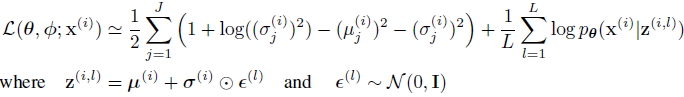

VAE 논문 Appendix B에서 KL divergence 유도 식,

Appendeix C에서 reconstruction loss 식 유도과정 확인 가능

In [ ]:
for epoch in range(num_epochs):
  model.train()
  cnt = 0
  rec_loss = 0
  kl_div_loss = 0
  total_loss = 0
  for i, (x, _) in enumerate(train_loader):   # label을 안받기에 이미지 부분만 X로 받음
    
    cnt += 1
    # Feed Forward
    x = x.to(device).view(-1, image_size)     # VAE 입력으로 넣기 위해 shape를 맞춤
    x_reconstructed, mu, log_var = model(x)

    # Compute total loss
    reconst_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Get Loss, Compute Gradient, Update Parameters
    loss = reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    rec_loss += reconst_loss.item()
    kl_div_loss += kl_div.item()
    total_loss += loss.item()

    # Print Loss
    if (i+1) % 200 == 0:
      print("Epoch[{}/{}], Step[{}/{}], Reconstruction Loss: {:.4f}, KL Divergence: {:.4f}, Total Loss: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), rec_loss/cnt, kl_div_loss/cnt, total_loss/cnt))

  # Save Generated Image and Recond
  model.eval()
  with torch.no_grad():
    # Save the sample images (for comparison)
    z = torch.randn(batch_size, z_dim).to(device)   # 임의의 분포 z 
    out = model.decoder(z).view(-1, 1, 28, 28)
    save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

    # Save the reconstructed images
    out, _, _ = model(x)
    x_concat = torch.cat([x.view(-1,1,28,28), out.view(-1,1,28,28)], dim=3)
    save_image(x_concat, os.path.join(sample_dir, 'reconstructed-{}.png'.format(epoch+1)))

# Save Model at the last epoch
torch.save(model.state_dict(), 'my_VAE_model.pth')

Epoch[1/20], Step[200/469], Reconstruction Loss: 23997.7767, KL Divergence: 1427.8943, Total Loss: 25425.6711
Epoch[1/20], Step[400/469], Reconstruction Loss: 19947.0574, KL Divergence: 1829.1089, Total Loss: 21776.1663
Epoch[2/20], Step[200/469], Reconstruction Loss: 13262.2921, KL Divergence: 2721.1400, Total Loss: 15983.4321
Epoch[2/20], Step[400/469], Reconstruction Loss: 12873.3455, KL Divergence: 2793.0478, Total Loss: 15666.3933
Epoch[3/20], Step[200/469], Reconstruction Loss: 11825.0171, KL Divergence: 2993.4156, Total Loss: 14818.4328
Epoch[3/20], Step[400/469], Reconstruction Loss: 11684.5356, KL Divergence: 3016.8132, Total Loss: 14701.3487
Epoch[4/20], Step[200/469], Reconstruction Loss: 11288.2417, KL Divergence: 3092.7518, Total Loss: 14380.9936
Epoch[4/20], Step[400/469], Reconstruction Loss: 11209.3813, KL Divergence: 3101.0190, Total Loss: 14310.4002
Epoch[5/20], Step[200/469], Reconstruction Loss: 10960.7693, KL Divergence: 3123.0721, Total Loss: 14083.8414
Epoch[5/20

#### Result
Reconstruncted-x.png: x epoch에서의 input과 output image

Sampled-x.png: x epoch에서 임의의 분포 z를 주었을 때 생성되는 image

추가자료

얼굴 이미지를 이용한 VAE 결과 예시

https://github.com/AntixK/PyTorch-VAE

<img src= "https://drive.google.com/uc?id=1cEJ22MokxRdtdOWZdZ7wD4WT4atz9dBQ" height=313 width = 656>

### (2) Transfer Learning

미리 학습된 모델을 불러와서 새로운 데이터셋에 대해 학습하는 기법

"Using pre-trained model"

* Resnet 18

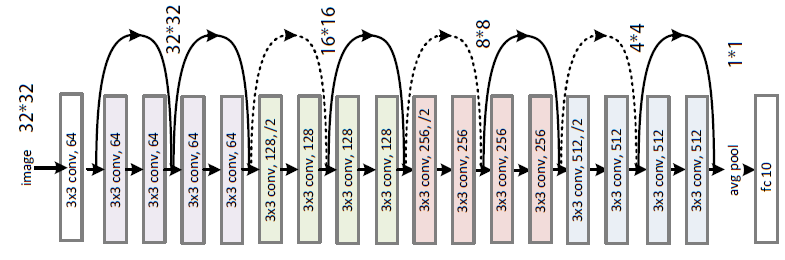

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

In [ ]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_class = 47
# hyper - parameters
num_epochs = 1
learning_rate = 0.005
batch_size = 128

In [ ]:
# Load Data
train_data = torchvision.datasets.EMNIST(root='./',
                                         split='bymerge',
                                         download=True,
                                         train=True,
                                         transform=transforms.ToTensor())
test_data = torchvision.datasets.EMNIST(root='./',
                                         split='bymerge',
                                         download=True,
                                         train=False,
                                         transform=transforms.ToTensor())

In [ ]:
# Define DataLoader
train_loader = torch.utils.data.DataLoader(train_data,
                                     batch_size=batch_size,
                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                     batch_size=batch_size,
                                     shuffle=False)

In [ ]:
# Define Model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
class MyResNet(nn.Module):
  def __init__(self, in_channels, model, num_classes):
    super(MyResNet, self).__init__()
    self.model = model
    self.model.conv1 = nn.Conv2d(in_channels, 64, 7,stride=2, padding=3, bias=False)
    self.model.fc = nn.Linear(512, num_classes)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.dropout(x)
    x = self.model(x)

    return x

In [ ]:
own = MyResNet(1,model,num_class).to(device)

In [ ]:
# Set Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(own.parameters(), lr = learning_rate)

In [ ]:
import time
from tqdm.auto import tqdm

In [ ]:
image, label = next(iter(test_loader))
print(image.size()) # [Batch, Channel, Height, Width]

torch.Size([128, 1, 28, 28])


In [ ]:
start = time.time()
best_epoch = 0
best_loss = float('inf')
total_step = len(train_loader)
loss_list = []

own.train()
for epoch in range(num_epochs):
  loss_step = 0
  for i, (image, label) in tqdm(enumerate(train_loader)):
    image = image.to(device)
    label = label.to(device)

    # Forward
    output = own(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_step += loss.item()

    if (i+1) % 500 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss_step/i))
      loss_list.append(loss_step/i)

end = time.time()
print("Train takes {:.2f}minutes".format((end-start)/60))

0it [00:00, ?it/s]

Epoch [1/1], Step[100/5453], Loss:1.1687
Epoch [1/1], Step[200/5453], Loss:1.0991
Epoch [1/1], Step[300/5453], Loss:0.8600
Epoch [1/1], Step[400/5453], Loss:0.7482
Epoch [1/1], Step[500/5453], Loss:0.6000
Epoch [1/1], Step[600/5453], Loss:0.5643
Epoch [1/1], Step[700/5453], Loss:0.4901
Epoch [1/1], Step[800/5453], Loss:0.4945
Epoch [1/1], Step[900/5453], Loss:0.5166
Epoch [1/1], Step[1000/5453], Loss:0.7095
Epoch [1/1], Step[1100/5453], Loss:0.3896
Epoch [1/1], Step[1200/5453], Loss:0.4597
Epoch [1/1], Step[1300/5453], Loss:0.5473
Epoch [1/1], Step[1400/5453], Loss:0.7768
Epoch [1/1], Step[1500/5453], Loss:0.4825
Epoch [1/1], Step[1600/5453], Loss:0.3907
Epoch [1/1], Step[1700/5453], Loss:0.8735
Epoch [1/1], Step[1800/5453], Loss:0.4585
Epoch [1/1], Step[1900/5453], Loss:0.3891
Epoch [1/1], Step[2000/5453], Loss:0.4391
Epoch [1/1], Step[2100/5453], Loss:0.4264
Epoch [1/1], Step[2200/5453], Loss:0.4989
Epoch [1/1], Step[2300/5453], Loss:0.4043
Epoch [1/1], Step[2400/5453], Loss:0.3089
E

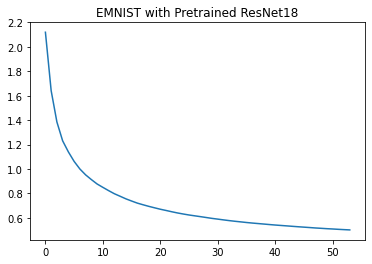

In [ ]:
plt.plot(loss_list)
plt.title("EMNIST with Pretrained ResNet18")
plt.show()

In [ ]:
own.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in tqdm(test_loader):
    img = img.to(device)
    lab = lab.to(device)
    out = own(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

  0%|          | 0/909 [00:00<?, ?it/s]

Accuracy of the network on the 116352 test images: 81.83873074807481%
